In [3]:
import sys
print(f"I am running Python from: {sys.executable}")
# If this says 'anaconda3', that confirms my theory.

I am running Python from: c:\ProgramData\anaconda3\python.exe


In [4]:
import sys

# Install torch AND torchvision with a long timeout to prevent crashing
# We use '--no-cache-dir' to force a fresh download if previous ones were corrupted
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --default-timeout=1000 --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu


In [31]:
import sys
import os

# 1. Define the missing path where pip installed PyTorch
# (I got this exact path from your screenshot)
user_site_packages = r"C:\Users\Lakshya Gupta\AppData\Roaming\Python\Python312\site-packages"

# 2. Add it to the system path if it's not there
if user_site_packages not in sys.path:
    sys.path.append(user_site_packages)
    print(f"Added to path: {user_site_packages}")

# 3. NOW try importing
import torch
import torchvision
print(" Success! PyTorch version:", torch.__version__)

Added to path: C:\Users\Lakshya Gupta\AppData\Roaming\Python\Python312\site-packages
 Success! PyTorch version: 2.9.1+cpu


In [6]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
import sys
import os

# Check which Python is running (Just for your info)
print(f"I am running Python from: {sys.executable}")

# Use the %pip magic command.
# This ensures packages are installed into the CURRENT running kernel/environment.
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --default-timeout=1000 --no-cache-dir
%pip install shap

# Now import
import torch
import torchvision
print("Success! PyTorch version:", torch.__version__)

I am running Python from: c:\Program Files\Python313\python.exe
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Success! PyTorch version: 2.9.1+cpu



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error

# 1. Load Data
print(" Loading Processed Data...")
train_df = pd.read_csv("processed_data/train_final.csv")
val_df = pd.read_csv("processed_data/val_final.csv")
feature_cols = joblib.load("processed_data/scale_cols.pkl")

X_train = train_df[feature_cols]
y_train = train_df['price_log']
X_val = val_df[feature_cols]
y_val = val_df['price_log']

print(f" Loaded {len(feature_cols)} features.")

# 2. Define the Champions 
# XGBoost: REMOVED 'early_stopping_rounds' to fix the crash
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    n_jobs=-1, 
    random_state=42
)

# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

# 3. Cross-Validation (The "Truth Serum")
print("\n Running 5-Fold Cross-Validation...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [("XGBoost", xgb_model), ("LightGBM", lgb_model), ("Random Forest", rf_model)]

for name, model in models:
    # We use 'r2' scoring to see accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2', n_jobs=1)
    print(f"   >> {name}: Average R² = {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# 4. The Ensemble (Voting Regressor) 
print("\n Training Ensemble (Voting Regressor)...")
ensemble = VotingRegressor(estimators=[
    ('xgb', xgb_model), 
    ('lgb', lgb_model), 
    ('rf', rf_model)
])

ensemble.fit(X_train, y_train)

# 5. Final Evaluation on Validation Set
preds_log = ensemble.predict(X_val)
r2 = r2_score(y_val, preds_log)
rmse = np.sqrt(mean_squared_error(y_val, preds_log))
mae_dollars = np.mean(np.abs(np.expm1(preds_log) - np.expm1(y_val)))

print("\n FINAL ENSEMBLE RESULTS")
print(f"R² Score:      {r2:.4f}")
print(f"RMSE (Log):    {rmse:.4f}")
print(f"MAE (Dollars): ${mae_dollars:,.0f}")


joblib.dump(ensemble, "processed_data/best_ensemble_model.pkl")
print("\n Model saved to 'processed_data/best_ensemble_model.pkl'")

 Loading Processed Data...
 Loaded 26 features.

 Running 5-Fold Cross-Validation...
   >> XGBoost: Average R² = 0.9021 (+/- 0.0030)
   >> LightGBM: Average R² = 0.9035 (+/- 0.0032)
   >> Random Forest: Average R² = 0.8849 (+/- 0.0040)

 Training Ensemble (Voting Regressor)...

 FINAL ENSEMBLE RESULTS
R² Score:      0.9015
RMSE (Log):    0.1681
MAE (Dollars): $64,686

 Model saved to 'processed_data/best_ensemble_model.pkl'


 Retraining single XGBoost model for SHAP analysis...
 Calculating SHAP Values...


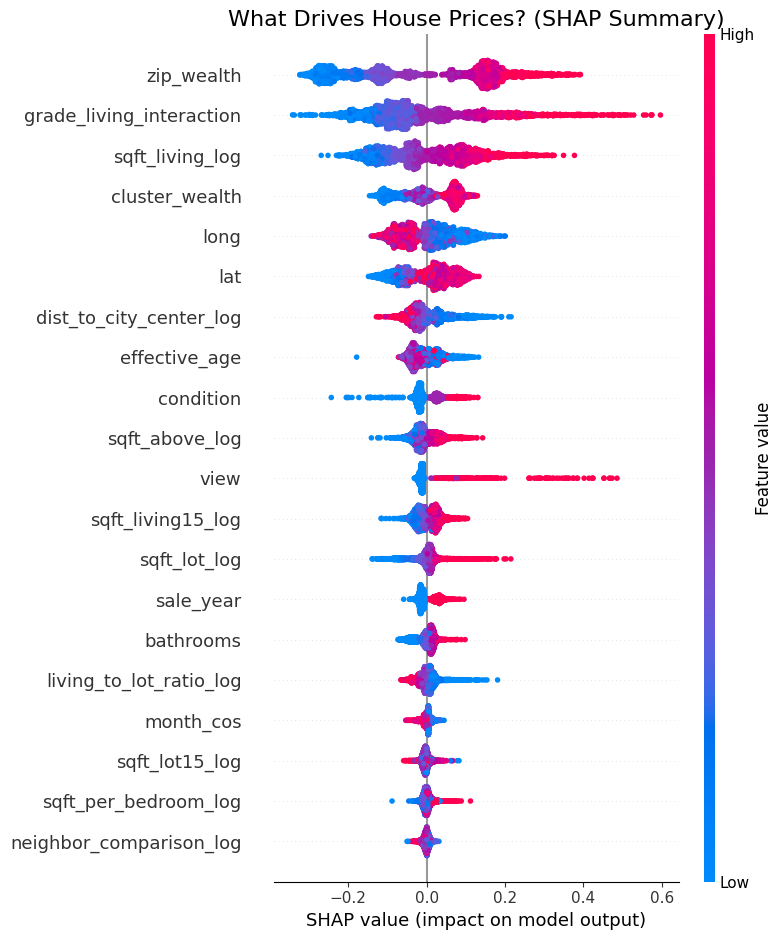


HOW TO READ THIS CHART:
1. Features at the TOP are the most important (likely 'zip_wealth' or 'grade').
2. RED dots = High value of that feature (e.g., Rich Zipcode).
3. BLUE dots = Low value (e.g., Poor Zipcode).
4. If RED dots are on the RIGHT, it means that feature INCREASES the price.



In [33]:
import shap
import matplotlib.pyplot as plt


print(" Retraining single XGBoost model for SHAP analysis...")
xgb_model.fit(X_train, y_train)


print(" Calculating SHAP Values...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

plt.figure(figsize=(10, 8))
plt.title("What Drives House Prices? (SHAP Summary)", fontsize=16)
shap.summary_plot(shap_values, X_val, show=False)
plt.show()


print("""
HOW TO READ THIS CHART:
1. Features at the TOP are the most important (likely 'zip_wealth' or 'grade').
2. RED dots = High value of that feature (e.g., Rich Zipcode).
3. BLUE dots = Low value (e.g., Poor Zipcode).
4. If RED dots are on the RIGHT, it means that feature INCREASES the price.
""")

 Training on device: cpu
 Loaded 26 features from scale_cols.pkl

--- Filtering Missing Images ---
Checking images for train_final.csv...


   Original: 12944 -> Valid: 12944 (Dropped 0)
Checking images for val_final.csv...


   Original: 3237 -> Valid: 3237 (Dropped 0)

--- Initializing Datasets ---

 Starting training for 25 epochs...


Epoch 1: Train Loss: 59.7473 | Val Loss: 1.5383 | Val RMSE: 1.2403 | Val R²: -4.3641
 yehh.. Model Saved (New Best R²: -4.3641)


Epoch 2: Train Loss: 1.9343 | Val Loss: 1.1878 | Val RMSE: 1.0899 | Val R²: -3.1418
 yehh.. Model Saved (New Best R²: -3.1418)


Epoch 3: Train Loss: 1.7713 | Val Loss: 1.2841 | Val RMSE: 1.1332 | Val R²: -3.4776


Epoch 4: Train Loss: 1.6767 | Val Loss: 0.9912 | Val RMSE: 0.9956 | Val R²: -2.4563
 yehh.. Model Saved (New Best R²: -2.4563)


Epoch 5: Train Loss: 1.6093 | Val Loss: 1.0220 | Val RMSE: 1.0109 | Val R²: -2.5637


Epoch 6: Train Loss: 1.5689 | Val Loss: 0.9727 | Val RMSE: 0.9863 | Val R²: -2.3920
 yehh.. Model Saved (New Best R²: -2.3920)


Epoch 7: Train Loss: 1.5073 | Val Loss: 1.0058 | Val RMSE: 1.0029 | Val R²: -2.5074


Epoch 8: Train Loss: 1.5226 | Val Loss: 0.8347 | Val RMSE: 0.9136 | Val R²: -1.9106
 yehh.. Model Saved (New Best R²: -1.9106)


Epoch 9: Train Loss: 1.4760 | Val Loss: 0.7968 | Val RMSE: 0.8926 | Val R²: -1.7784
 yehh.. Model Saved (New Best R²: -1.7784)


Epoch 10: Train Loss: 1.4104 | Val Loss: 0.8733 | Val RMSE: 0.9345 | Val R²: -2.0454


Epoch 11: Train Loss: 1.3708 | Val Loss: 0.7608 | Val RMSE: 0.8722 | Val R²: -1.6528
 yehh.. Model Saved (New Best R²: -1.6528)


Epoch 12: Train Loss: 1.3606 | Val Loss: 0.8076 | Val RMSE: 0.8987 | Val R²: -1.8163


Epoch 13: Train Loss: 1.3167 | Val Loss: 0.6704 | Val RMSE: 0.8188 | Val R²: -1.3379
 yehh.. Model Saved (New Best R²: -1.3379)


Epoch 14: Train Loss: 1.3000 | Val Loss: 0.7056 | Val RMSE: 0.8400 | Val R²: -1.4606


Epoch 15: Train Loss: 1.2471 | Val Loss: 0.6429 | Val RMSE: 0.8018 | Val R²: -1.2418
 yehh.. Model Saved (New Best R²: -1.2418)


Epoch 16: Train Loss: 1.2153 | Val Loss: 0.6249 | Val RMSE: 0.7905 | Val R²: -1.1791
 yehh.. Model Saved (New Best R²: -1.1791)


Epoch 17: Train Loss: 1.1846 | Val Loss: 0.5785 | Val RMSE: 0.7606 | Val R²: -1.0172
 yehh.. Model Saved (New Best R²: -1.0172)


Epoch 18: Train Loss: 1.1286 | Val Loss: 0.7395 | Val RMSE: 0.8599 | Val R²: -1.5787


Epoch 19: Train Loss: 1.1052 | Val Loss: 0.5340 | Val RMSE: 0.7308 | Val R²: -0.8622
 yehh.. Model Saved (New Best R²: -0.8622)


Epoch 20: Train Loss: 1.0809 | Val Loss: 0.6005 | Val RMSE: 0.7749 | Val R²: -1.0938


Epoch 21: Train Loss: 1.0724 | Val Loss: 0.4829 | Val RMSE: 0.6949 | Val R²: -0.6839
 yehh.. Model Saved (New Best R²: -0.6839)


Epoch 22: Train Loss: 1.0384 | Val Loss: 0.4856 | Val RMSE: 0.6968 | Val R²: -0.6932


Epoch 23: Train Loss: 0.9843 | Val Loss: 0.5185 | Val RMSE: 0.7201 | Val R²: -0.8082


Epoch 24: Train Loss: 0.9634 | Val Loss: 0.4253 | Val RMSE: 0.6522 | Val R²: -0.4832
 yehh.. Model Saved (New Best R²: -0.4832)


Epoch 25: Train Loss: 0.9291 | Val Loss: 0.4235 | Val RMSE: 0.6508 | Val R²: -0.4768
 yehh.. Model Saved (New Best R²: -0.4768)


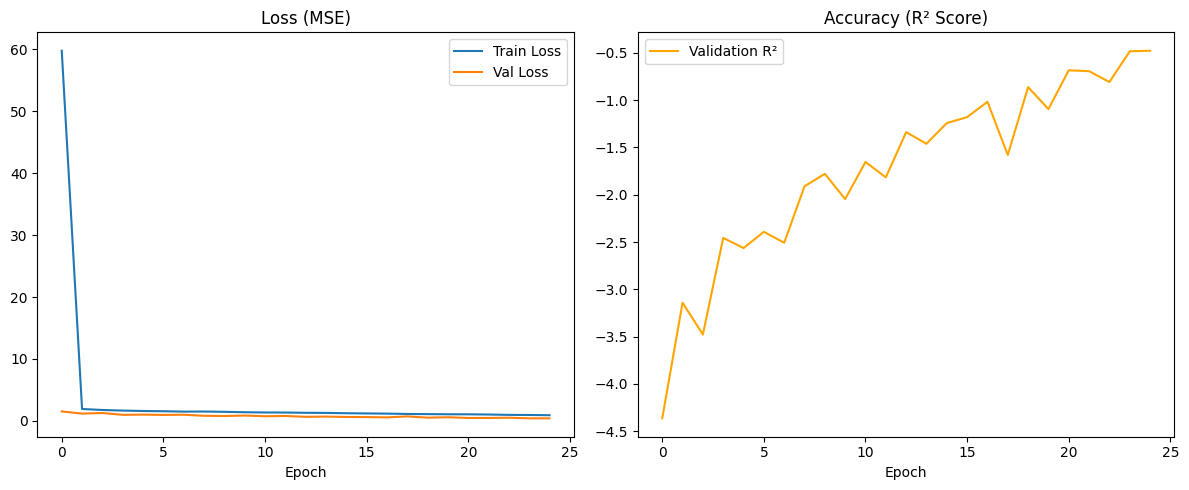

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import r2_score

# --- CONFIGURATION ---
OUTPUT_DIR = "processed_data"
TRAIN_CSV = os.path.join(OUTPUT_DIR, "train_final.csv")
VAL_CSV = os.path.join(OUTPUT_DIR, "val_final.csv")
SCALE_COLS_PATH = os.path.join(OUTPUT_DIR, "scale_cols.pkl")

# Update this path if needed
IMAGE_DIR = r"E:\cdc_project\images_mapbox_zoom18"

BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f" Training on device: {DEVICE}")

# --- STEP 1: LOAD FEATURE LIST ---
try:
    feature_cols = joblib.load(SCALE_COLS_PATH)
    print(f" Loaded {len(feature_cols)} features from scale_cols.pkl")
except FileNotFoundError:
    print(" Error: scale_cols.pkl not found. Using fallback list.")
    feature_cols = [
        'bedrooms', 'bathrooms', 'floors', 'lat', 'long',
        'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
        'sqft_living15_log', 'sqft_lot15_log',
        'condition', 'grade', 'view',
        'dist_to_city_center', 'living_to_lot_ratio', 'neighbor_comparison',
        'sqft_per_bedroom', 'grade_living_interaction', 'effective_age',
        'renovation_impact', 'zip_wealth', 'cluster_wealth', 
        'size_diff_from_neighbors'
    ]

# --- STEP 2: HELPER FUNCTION (Filter Missing Images) ---
def filter_missing_images(csv_path, img_dir):
    """
    Checks if images exist for each row in the CSV.
    Returns a filtered DataFrame containing only valid rows.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
        
    df = pd.read_csv(csv_path)
    valid_rows = []
    
    print(f"Checking images for {os.path.basename(csv_path)}...")
    # Check first 5 to ensure path logic is correct, then loop all
    for idx, row in tqdm(df.iterrows(), total=len(df), leave=False):
        img_id = str(row['id']).replace('.0', '')
        img_path = os.path.join(img_dir, f"{img_id}.jpg")
        
        if os.path.exists(img_path):
            valid_rows.append(row)
            
    print(f"   Original: {len(df)} -> Valid: {len(valid_rows)} (Dropped {len(df)-len(valid_rows)})")
    return pd.DataFrame(valid_rows)

# --- STEP 3: CUSTOM DATASET CLASS ---
class RealEstateDataset(Dataset):
    def __init__(self, data_input, img_dir, feature_columns, transform=None):
        """
        Args:
            data_input: Either a path to a CSV file (str) OR a pandas DataFrame.
            img_dir: Path to image folder.
            feature_columns: List of columns to use as tabular features.
            transform: PyTorch transforms for images.
        """
        # FIX: Handle both CSV path strings AND DataFrames
        if isinstance(data_input, str):
            self.data = pd.read_csv(data_input)
        else:
            self.data = data_input.reset_index(drop=True)
            
        self.img_dir = img_dir
        self.transform = transform
        self.feature_cols = feature_columns
        
        # Target: Log Price
        self.targets = self.data['price_log'].values.astype('float32')
        
        # Features: Only select the scaled columns
        self.features = self.data[self.feature_cols].values.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 1. Load Image using ID
        row = self.data.iloc[idx]
        img_id = str(row['id']).replace('.0', '')
        img_name = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_name).convert('RGB')
        except (FileNotFoundError, OSError):
            # Fallback (shouldn't happen if filtered correctly)
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        # 2. Load Tabular Data
        tabular = self.features[idx]
        
        # 3. Load Target
        label = self.targets[idx]

        return image, torch.tensor(tabular), torch.tensor(label)

#  MODEL ARCHITECTURE
class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        
        # IMAGE HEAD (Pre-trained ResNet18)
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # FREEZE WEIGHTS (Anti-Overfitting / Anti-Forgetting) 
        for param in resnet.parameters():
            param.requires_grad = False

        # Remove the final classification layer (fc)
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        # B. TABULAR HEAD (MLP)
        self.tabular_extractor = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout to fight overfitting
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # C. FUSION HEAD (Concatenation)
        # ResNet18 outputs 512 dim vector + Tabular 64 dim = 576
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Output: 1 regression value
        )

    def forward(self, image, tabular):
        # Image Path
        x_img = self.image_extractor(image)
        x_img = x_img.view(x_img.size(0), -1) # Flatten (batch_size, 512)
        
        # Tabular Path
        x_tab = self.tabular_extractor(tabular) # (batch_size, 64)
        
        # Combine
        combined = torch.cat((x_img, x_tab), dim=1) # (batch_size, 576)
        
        # Predict
        output = self.fusion(combined)
        return output


# Standard ResNet transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("\n--- Filtering Missing Images ---")
train_df = filter_missing_images(TRAIN_CSV, IMAGE_DIR)
val_df = filter_missing_images(VAL_CSV, IMAGE_DIR)

print("\n--- Initializing Datasets ---")
train_dataset = RealEstateDataset(train_df, IMAGE_DIR, feature_cols, transform=data_transform)
val_dataset = RealEstateDataset(val_df, IMAGE_DIR, feature_cols, transform=data_transform)

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


model = MultimodalNet(len(feature_cols)).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)


def train_model(epochs):
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_r2': []}

    print(f"\n Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        
        for images, tabs, labels in train_bar:
            images = images.to(DEVICE)
            tabs = tabs.to(DEVICE)
            labels = labels.to(DEVICE).float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(images, tabs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            train_bar.set_postfix(loss=loss.item())
            
        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        # VALIDATE 
        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for images, tabs, labels in val_loader:
                images = images.to(DEVICE)
                tabs = tabs.to(DEVICE)
                labels = labels.to(DEVICE).float().view(-1, 1)
                
                outputs = model(images, tabs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                
                # Collect for R2
                val_preds.extend(outputs.cpu().numpy().flatten())
                val_targets.extend(labels.cpu().numpy().flatten())
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_r2 = r2_score(val_targets, val_preds)
        
        history['val_loss'].append(val_loss)
        history['val_r2'].append(val_r2)
        
        rmse = np.sqrt(val_loss)
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val RMSE: {rmse:.4f} | Val R²: {val_r2:.4f}")
        
    
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_multimodal_model.pth")
            print(f" yehh.. Model Saved (New Best R²: {val_r2:.4f})")


    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_r2'], color='orange', label='Validation R²')
    plt.title('Accuracy (R² Score)')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return history

if __name__ == "__main__":
    history = train_model(EPOCHS)

 Loading saved training data...
 Loaded train_df: (12944, 52)
 Loaded 21 features from scale_cols.pkl

 Analyzing Feature Importance with Random Forest...


C:\Users\Lakshya Gupta\AppData\Local\Temp\ipykernel_39968\1262206181.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


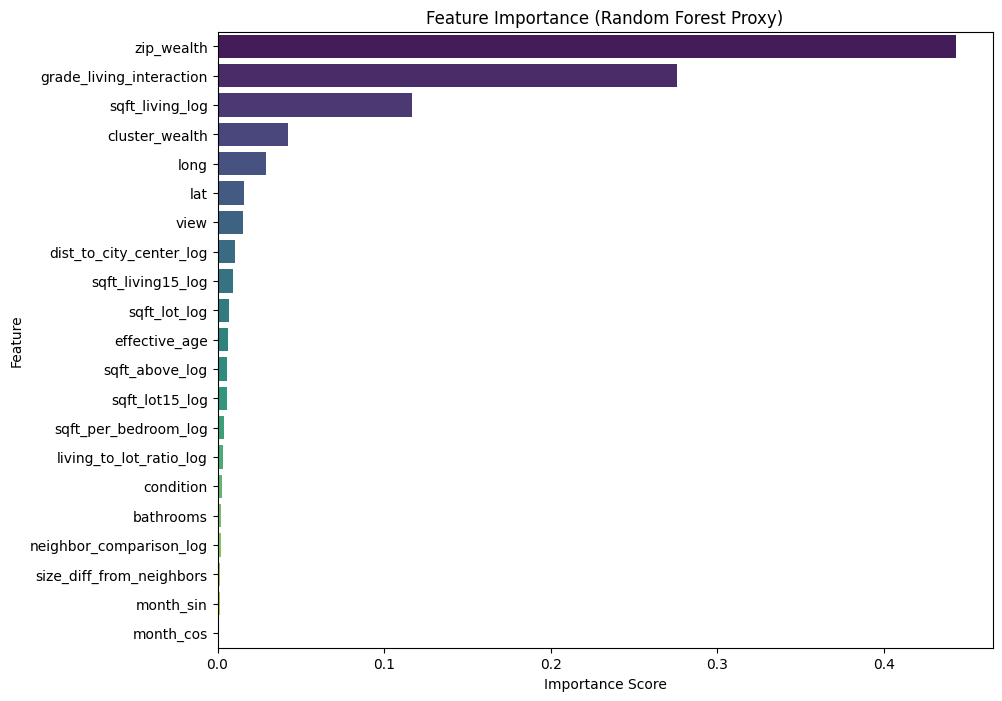


-----------------------------------------
 CANDIDATES TO DROP (Bottom 5 Features):
                     Feature  Importance
20                 bathrooms    0.002218
17   neighbor_comparison_log    0.001857
12  size_diff_from_neighbors    0.001638
18                 month_sin    0.001223
19                 month_cos    0.000923
-----------------------------------------


In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import os

# --- 1. LOAD SAVED DATA (The Shortcut) ---
print(" Loading saved training data...")

# Load the processed CSV
try:
    train_df = pd.read_csv("processed_data/train_final.csv")
    print(f" Loaded train_df: {train_df.shape}")
except FileNotFoundError:
    print(" Error: 'train_final.csv' not found. You must run preprocessing.ipynb first.")

# Load the feature list
try:
    scale_cols = joblib.load("processed_data/scale_cols.pkl")
    print(f" Loaded {len(scale_cols)} features from scale_cols.pkl")
except FileNotFoundError:
    print(" Error: 'scale_cols.pkl' not found.")

# --- 2. RUN FEATURE IMPORTANCE ---
if 'train_df' in locals() and 'scale_cols' in locals():
    print("\n Analyzing Feature Importance with Random Forest...")
    
    # Train a quick Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(train_df[scale_cols], train_df['price_log'])

    # Get Scores
    importances = rf.feature_importances_
    feature_imp = pd.DataFrame({'Feature': scale_cols, 'Importance': importances})
    feature_imp = feature_imp.sort_values(by='Importance', ascending=False)

    # Visualize
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
    plt.title("Feature Importance (Random Forest Proxy)")
    plt.xlabel("Importance Score")
    plt.show()

    # The Verdict
    print("\n-----------------------------------------")
    print(" CANDIDATES TO DROP (Bottom 5 Features):")
    print(feature_imp.tail(5))
    print("-----------------------------------------")

 Training with optimized list of 21 features

Starting Training (Stable Version).


Epoch 1: Train Loss=0.0761 | Val Loss=0.0370 | Val R²=0.8711
 good.. Saved New Best Model! (R²: 0.8711)


Epoch 2: Train Loss=0.0490 | Val Loss=0.0357 | Val R²=0.8755
 good.. Saved New Best Model! (R²: 0.8755)


Epoch 3: Train Loss=0.0474 | Val Loss=0.0350 | Val R²=0.8781
 good.. Saved New Best Model! (R²: 0.8781)


Epoch 4: Train Loss=0.0455 | Val Loss=0.0447 | Val R²=0.8442


Epoch 5: Train Loss=0.0453 | Val Loss=0.0357 | Val R²=0.8756


Epoch 6: Train Loss=0.0433 | Val Loss=0.0367 | Val R²=0.8721


Epoch 7: Train Loss=0.0437 | Val Loss=0.0409 | Val R²=0.8572


Epoch 8: Train Loss=0.0412 | Val Loss=0.0390 | Val R²=0.8639


Epoch 9: Train Loss=0.0396 | Val Loss=0.0375 | Val R²=0.8692


Epoch 10: Train Loss=0.0415 | Val Loss=0.0348 | Val R²=0.8787
 good.. Saved New Best Model! (R²: 0.8787)


Epoch 11: Train Loss=0.0396 | Val Loss=0.0346 | Val R²=0.8792
 good.. Saved New Best Model! (R²: 0.8792)


Epoch 12: Train Loss=0.0391 | Val Loss=0.0334 | Val R²=0.8835
 good.. Saved New Best Model! (R²: 0.8835)


Epoch 13: Train Loss=0.0392 | Val Loss=0.0387 | Val R²=0.8651


Epoch 14: Train Loss=0.0392 | Val Loss=0.0381 | Val R²=0.8670


Epoch 15: Train Loss=0.0389 | Val Loss=0.0347 | Val R²=0.8788


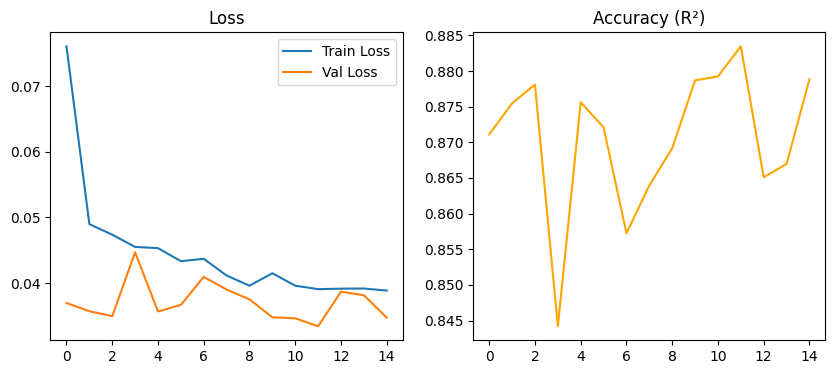

In [2]:
import sys
import os
import joblib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import r2_score

# --- CONFIGURATION ---
BATCH_SIZE = 32
LEARNING_RATE = 0.0005  # Faster learning
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "processed_data"
IMAGE_DIR = r"E:\cdc_project\images_mapbox_zoom18"

# --- LOAD DATA ---
train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_final.csv"))
val_df = pd.read_csv(os.path.join(OUTPUT_DIR, "val_final.csv"))

# --- OPTIMIZED FEATURE LIST (The "Friend's List") ---
final_features = [
    'lat', 'long', 'zip_wealth', 'cluster_wealth', 'dist_to_city_center_log',
    'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
    'sqft_living15_log', 'sqft_lot15_log', 'sqft_per_bedroom_log',
    'living_to_lot_ratio_log', 'size_diff_from_neighbors',
    'grade_living_interaction', 'view', 'condition', 'effective_age',
    'neighbor_comparison_log', 'month_sin', 'month_cos', 'bathrooms'
]

# Save this list so we can use it for submission later
joblib.dump(final_features, os.path.join(OUTPUT_DIR, "scale_cols.pkl"))
print(f" Training with optimized list of {len(final_features)} features")

# --- DATASET CLASS ---
class RealEstateDataset(Dataset):
    def __init__(self, dataframe, img_dir, feature_cols, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.feature_cols = feature_cols
        self.transform = transform
        self.targets = self.data['price_log'].values.astype('float32')
        self.features = self.data[self.feature_cols].values.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = str(row['id']).replace('.0', '')
        img_name = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_name).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='black')
            
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(self.features[idx]), torch.tensor(self.targets[idx])

# --- TRANSFORM & LOADERS ---
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = RealEstateDataset(train_df, IMAGE_DIR, final_features, transform=data_transform)
val_dataset = RealEstateDataset(val_df, IMAGE_DIR, final_features, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- MODEL ---
class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        # Freeze ResNet for stability
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False
            
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        self.tabular_extractor = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Initialize bias to 13.0 to prevent negative R2 start
        nn.init.constant_(self.fusion[-1].bias, 13.0)

    def forward(self, image, tabular):
        x_img = self.image_extractor(image).view(image.size(0), -1)
        x_tab = self.tabular_extractor(tabular)
        combined = torch.cat((x_img, x_tab), dim=1)
        return self.fusion(combined)

model = MultimodalNet(len(final_features)).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 6. TRAINING LOOP (CORRECTED) ---
print("\nStarting Training (Stable Version).")
best_r2 = -float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_r2': []} # <--- Added History Tracking

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for images, tabs, labels in train_bar:
        images, tabs, labels = images.to(DEVICE), tabs.to(DEVICE), labels.to(DEVICE).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(images, tabs)
        loss = criterion(outputs, labels)
        loss.backward()
        
    
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        train_bar.set_postfix(loss=loss.item())

    # Calculate Average Train Loss
    epoch_train_loss = running_loss / len(train_dataset)
    history['train_loss'].append(epoch_train_loss)

    # --- VALIDATE ---
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for images, tabs, labels in val_loader:
            images, tabs, labels = images.to(DEVICE), tabs.to(DEVICE), labels.to(DEVICE).float().view(-1, 1)
            outputs = model(images, tabs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            val_preds.extend(outputs.cpu().numpy().flatten())
            val_targets.extend(labels.cpu().numpy().flatten())
    
    # Calculate Val Metrics
    val_loss /= len(val_dataset)
    val_r2 = r2_score(val_targets, val_preds)
    
    history['val_loss'].append(val_loss)
    history['val_r2'].append(val_r2)
    
    # Print Full Stats
    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f} | Val Loss={val_loss:.4f} | Val R²={val_r2:.4f}")
    
    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(model.state_dict(), "best_multimodal_model.pth")
        print(f" good.. Saved New Best Model! (R²: {best_r2:.4f})")

# Optional: Plot the training curve at the end
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_r2'], color='orange', label='Val R²')
plt.title('Accuracy (R²)')
plt.show()

In [3]:
# --- STAGE 2: FINE-TUNING ---
print("\nFine-Tuning (Unfreezing Vision)...")

# 1. Load your best saved model (The 88.35% one)
checkpoint = torch.load("best_multimodal_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint)

# 2. Unfreeze the last block of ResNet (Let it learn specific house features)
# We only unfreeze 'layer4' to be safe and save memory
for param in model.image_extractor[-2].parameters(): # Access the last ResNet block
    param.requires_grad = True

# 3. Use a much LOWER Learning Rate (Crucial for fine-tuning)
# If we use 0.0005, we will destroy the weights. We use 1e-5.
optimizer = optim.Adam(model.parameters(), lr=0.00002) 

# 4. Train for 5-8 more epochs
FINE_TUNE_EPOCHS = 8
best_r2 = 0.8835 # Start with your current best

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Fine-Tune Epoch {epoch+1}/{FINE_TUNE_EPOCHS}", leave=False)
    
    for images, tabs, labels in train_bar:
        images, tabs, labels = images.to(DEVICE), tabs.to(DEVICE), labels.to(DEVICE).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(images, tabs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Keep Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        train_bar.set_postfix(loss=loss.item())

    # Validate
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for images, tabs, labels in val_loader:
            images, tabs, labels = images.to(DEVICE), tabs.to(DEVICE), labels.to(DEVICE).float().view(-1, 1)
            outputs = model(images, tabs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_preds.extend(outputs.cpu().numpy().flatten())
            val_targets.extend(labels.cpu().numpy().flatten())
    
    val_loss /= len(val_dataset)
    val_r2 = r2_score(val_targets, val_preds)
    
    print(f"Fine-Tune {epoch+1}: Val Loss={val_loss:.4f} | Val R²={val_r2:.4f}")
    
    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(model.state_dict(), "best_multimodal_model_finetuned.pth")
        print(f"  DIAMOND MODEL SAVED! (R²: {best_r2:.4f})")


Fine-Tuning (Unfreezing Vision)...


Fine-Tune 1: Val Loss=0.0329 | Val R²=0.8852
  DIAMOND MODEL SAVED! (R²: 0.8852)


Fine-Tune 2: Val Loss=0.0347 | Val R²=0.8790


Fine-Tune 3: Val Loss=0.0352 | Val R²=0.8771


Fine-Tune 4: Val Loss=0.0361 | Val R²=0.8740


Fine-Tune 5: Val Loss=0.0384 | Val R²=0.8662


Fine-Tune 6: Val Loss=0.0381 | Val R²=0.8671


Fine-Tune 7: Val Loss=0.0410 | Val R²=0.8570


Fine-Tune 8: Val Loss=0.0413 | Val R²=0.8560


In [21]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import joblib 

# --- CONFIGURATION ---
RAW_TEST_PATH = r"C:\Users\Lakshya Gupta\Downloads\test2(test(1)).csv"
TRAIN_FINAL_PATH = "processed_data/train_final.csv"
OUTPUT_TEST_PATH = "processed_data/test_final.csv"
SCALER_PATH = "processed_data/scaler.pkl"        

# 1. Load Data
try:
    test_df = pd.read_csv(RAW_TEST_PATH)
    train_df = pd.read_csv(TRAIN_FINAL_PATH)
    print("Raw Data Loaded.")
except FileNotFoundError:
    print(f"Error: Could not find files.")
    raise

# 2. Date Features
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['sale_month'] = test_df['date'].dt.month
test_df['sale_year'] = test_df['date'].dt.year
test_df['month_sin'] = np.sin(2 * np.pi * test_df['sale_month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['sale_month'] / 12)

# 3. Log Transformations
cols_to_log = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_per_bedroom']

# Create sqft_per_bedroom
if 'sqft_per_bedroom' not in test_df.columns:
    if 'bedrooms' in test_df.columns and 'sqft_living' in test_df.columns:
        # Avoid Division by Zero if bedrooms is 0
        test_df['sqft_per_bedroom'] = test_df['sqft_living'] / test_df['bedrooms'].replace(0, 1)
    else:
        test_df['sqft_per_bedroom'] = 0

for col in cols_to_log:
    if col in test_df.columns:
        test_df[f'{col}_log'] = np.log1p(test_df[col])
    else:
        test_df[f'{col}_log'] = 0 

# 4. Ratios & Interactions
if 'sqft_living' in test_df.columns and 'sqft_lot' in test_df.columns:
    # Avoid Division by Zero
    test_df['living_to_lot_ratio'] = test_df['sqft_living'] / test_df['sqft_lot'].replace(0, 1)
    test_df['living_to_lot_ratio_log'] = np.log1p(test_df['living_to_lot_ratio'])
else:
    test_df['living_to_lot_ratio_log'] = 0

if 'sqft_living' in test_df.columns and 'sqft_living15' in test_df.columns:
    test_df['size_diff_from_neighbors'] = test_df['sqft_living'] - test_df['sqft_living15']
else:
    test_df['size_diff_from_neighbors'] = 0

if 'grade' in test_df.columns and 'sqft_living_log' in test_df.columns:
    test_df['grade_living_interaction'] = test_df['grade'] * test_df['sqft_living_log']
else:
    test_df['grade_living_interaction'] = 0

# Effective Age
if 'yr_renovated' not in test_df.columns: test_df['yr_renovated'] = 0
if 'yr_built' not in test_df.columns: test_df['yr_built'] = test_df['sale_year']

test_df['effective_yr'] = test_df.apply(lambda x: x['yr_renovated'] if x['yr_renovated'] > 0 else x['yr_built'], axis=1)
test_df['effective_age'] = test_df['sale_year'] - test_df['effective_yr']

# Renovation Impact 
test_df['renovation_impact'] = test_df.apply(lambda x: 1 if x['yr_renovated'] > 0 else 0, axis=1)

# 5. Distance to City Center
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

if 'lat' in test_df.columns and 'long' in test_df.columns:
    test_df['dist_to_city_center'] = haversine_np(test_df['lat'], test_df['long'], 47.6062, -122.3321)
    test_df['dist_to_city_center_log'] = np.log1p(test_df['dist_to_city_center'])
else:
    test_df['dist_to_city_center_log'] = 0

# 6. Wealth Mappings
zip_wealth_map = train_df.groupby('zipcode')['zip_wealth'].mean().to_dict()
global_mean_wealth = train_df['zip_wealth'].mean()
test_df['zip_wealth'] = test_df['zipcode'].map(zip_wealth_map).fillna(global_mean_wealth)

print(" Inferring Cluster Wealth using KNN...")
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(train_df[['lat', 'long']], train_df['cluster_wealth'])
test_df['cluster_wealth'] = knn.predict(test_df[['lat', 'long']])

# 7. Neighbor Comparison
if 'neighbor_comparison' not in test_df.columns:
    if 'sqft_living' in test_df.columns and 'sqft_living15' in test_df.columns:
        # Avoid Division by Zero
        test_df['neighbor_comparison'] = test_df['sqft_living'] / test_df['sqft_living15'].replace(0, 1)
    else:
        test_df['neighbor_comparison'] = 1.0
test_df['neighbor_comparison_log'] = np.log1p(test_df['neighbor_comparison'])

# Replace Infinity with 0
test_df.replace([np.inf, -np.inf], 0, inplace=True)
# Replace NaN with 0
test_df.fillna(0, inplace=True)
print("Data Sanitized (Inf/NaN removed).")

# SCALING
print("Applying Scaler...")
scaler = joblib.load(SCALER_PATH)

# Get the TRUE list of features the scaler wants
try:
    true_scale_cols = list(scaler.feature_names_in_)
except AttributeError:
    print("Warning: Old sklearn detected. Using scale_cols.pkl as backup.")
    true_scale_cols = joblib.load("processed_data/scale_cols.pkl")

print(f"   Scaler requires {len(true_scale_cols)} columns.")

# Force-create ALL missing columns
missing_cols = [c for c in true_scale_cols if c not in test_df.columns]
if missing_cols:
    print(f"   Creating missing columns: {missing_cols}")
    for c in missing_cols:
        test_df[c] = 0 # Safe default

# Ensure columns are in the EXACT order the scaler learned
test_df_for_scaling = test_df[true_scale_cols]

# Apply Transform
test_df[true_scale_cols] = scaler.transform(test_df_for_scaling)
print("Scaler applied successfully.")

# 8. Save
test_df.to_csv(OUTPUT_TEST_PATH, index=False)
print(f"SUCCESS! Scaled Test Data saved to: {OUTPUT_TEST_PATH}")

Raw Data Loaded.
 Inferring Cluster Wealth using KNN...
Data Sanitized (Inf/NaN removed).
Applying Scaler...
   Scaler requires 26 columns.
Scaler applied successfully.
SUCCESS! Scaled Test Data saved to: processed_data/test_final.csv


In [22]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import joblib


TEST_CSV_PATH = "processed_data/test_final.csv"
ENSEMBLE_PATH = "processed_data/best_ensemble_model.pkl"
NN_PATH = "best_multimodal_model_finetuned.pth"
IMAGE_DIR = r"E:\cdc_project\images_mapbox_zoom18"
OUTPUT_SUBMISSION_PATH = "submission_final.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_df = pd.read_csv(TEST_CSV_PATH)
ids = test_df['id'].values # Save IDs for the submission file


scaler = joblib.load("processed_data/scaler.pkl")
ensemble_features = list(scaler.feature_names_in_) 
X_test_ensemble = test_df[ensemble_features].values

# B. For Neural Network (Expects only the 21 Optimized Features)
nn_features_list = [
    'lat', 'long', 'zip_wealth', 'cluster_wealth', 'dist_to_city_center_log',
    'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
    'sqft_living15_log', 'sqft_lot15_log', 'sqft_per_bedroom_log',
    'living_to_lot_ratio_log', 'size_diff_from_neighbors',
    'grade_living_interaction', 'view', 'condition', 'effective_age',
    'neighbor_comparison_log', 'month_sin', 'month_cos', 'bathrooms'
]

print(f"Running Ensemble (XGBoost+LightGBM) on {len(ensemble_features)} features...")
try:
    ensemble_model = joblib.load(ENSEMBLE_PATH)
    preds_ensemble = ensemble_model.predict(X_test_ensemble)
except Exception as e:
    print(f"Ensemble Failed: {e}")
    preds_ensemble = np.zeros(len(test_df))


print(f"Running Neural Network on {len(nn_features_list)} features...")

# Re-define the class exactly as trained
class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        resnet = models.resnet18(weights=None) # No need for weights, we load them next
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.tabular_extractor = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, image, tabular):
        x_img = self.image_extractor(image).view(image.size(0), -1)
        x_tab = self.tabular_extractor(tabular)
        combined = torch.cat((x_img, x_tab), dim=1)
        return self.fusion(combined)

# Dataset Class for Inference
class TestDataset(Dataset):
    def __init__(self, df, img_dir, feature_cols):
        self.df = df
        self.img_dir = img_dir
        self.features = df[feature_cols].values.astype('float32')
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row['id']).replace('.0', '')
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='black')
        
        return self.transform(image), torch.tensor(self.features[idx])

# Initialize
test_dataset = TestDataset(test_df, IMAGE_DIR, nn_features_list)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0) # Safe for Windows

# Load Model
nn_model = MultimodalNet(len(nn_features_list)).to(DEVICE)
nn_model.load_state_dict(torch.load(NN_PATH, map_location=DEVICE))
nn_model.eval()

# Predict Loop
preds_neural = []
with torch.no_grad():
    for images, tabs in tqdm(test_loader, desc="Neural Inference"):
        images, tabs = images.to(DEVICE), tabs.to(DEVICE)
        outputs = nn_model(images, tabs)
        preds_neural.extend(outputs.cpu().numpy().flatten())

preds_neural = np.array(preds_neural)
print("Neural Network Predictions Complete.")

# 5. BLEND & EXPORT 
print("Blending Models (50% Tabular / 50% Visual)...")

# Weighted Average (Adjust weights if you trust one model more)
final_log_preds = (0.5 * preds_ensemble) + (0.5 * preds_neural)

# Convert Log Price -> Real Price
final_price = np.expm1(final_log_preds)

# Create Submission DataFrame
submission = pd.DataFrame({
    'id': ids,
    'price': final_price
})

submission.to_csv(OUTPUT_SUBMISSION_PATH, index=False)
print(f"Submission saved to: {OUTPUT_SUBMISSION_PATH}")
print(submission.head())

Running Ensemble (XGBoost+LightGBM) on 26 features...


C:\Users\Lakshya Gupta\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lakshya Gupta\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Running Neural Network on 21 features...


Neural Inference: 100%|██████████| 169/169 [01:05<00:00,  2.58it/s]

Neural Network Predictions Complete.
Blending Models (50% Tabular / 50% Visual)...
Submission saved to: submission_final.csv
           id         price
0  2591820310  21197.342757
1  7974200820  37612.869168
2  7701450110  46892.528714
3  9522300010  59217.974800
4  9510861140  30486.232516


In [23]:
import pandas as pd

# Load the processed file you just created
df_test = pd.read_csv("processed_data/test_final.csv")

print("REPORT")


# Check 3 Critical Features
cols_to_check = ['sqft_living_log', 'zip_wealth', 'grade_living_interaction']

for col in cols_to_check:
    if col in df_test.columns:
        mean_val = df_test[col].mean()
        min_val = df_test[col].min()
        print(f"Feature: {col}")
        print(f"   Mean: {mean_val:.4f} (Should be near 0.0)")
        print(f"   Min:  {min_val:.4f}  (If this is < -10, we found the bug!)")
        print("-" * 20)
    else:
        print(f" MISSING: {col}")

REPORT
Feature: sqft_living_log
   Mean: 0.0144 (Should be near 0.0)
   Min:  -3.7845  (If this is < -10, we found the bug!)
--------------------
Feature: zip_wealth
   Mean: -34.3948 (Should be near 0.0)
   Min:  -39.1239  (If this is < -10, we found the bug!)
--------------------
Feature: grade_living_interaction
   Mean: 0.0092 (Should be near 0.0)
   Min:  -2.9535  (If this is < -10, we found the bug!)
--------------------


In [25]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import joblib 

# --- CONFIGURATION ---
RAW_TEST_PATH = r"C:\Users\Lakshya Gupta\Downloads\test2(test(1)).csv"
TRAIN_FINAL_PATH = "processed_data/train_final.csv"
OUTPUT_TEST_PATH = "processed_data/test_final.csv"
SCALER_PATH = "processed_data/scaler.pkl"        


# 1. Load Data
test_df = pd.read_csv(RAW_TEST_PATH)
train_df = pd.read_csv(TRAIN_FINAL_PATH) # This has SCALED features


if 'price_log' not in train_df.columns:
    train_df['price_log'] = np.log1p(train_df['price'])

# 2. Date Features
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['sale_month'] = test_df['date'].dt.month
test_df['sale_year'] = test_df['date'].dt.year
test_df['month_sin'] = np.sin(2 * np.pi * test_df['sale_month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['sale_month'] / 12)

# 3. Log Transformations
cols_to_log = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_per_bedroom']

# Create sqft_per_bedroom
if 'sqft_per_bedroom' not in test_df.columns:
    if 'bedrooms' in test_df.columns and 'sqft_living' in test_df.columns:
        test_df['sqft_per_bedroom'] = test_df['sqft_living'] / test_df['bedrooms'].replace(0, 1)
    else:
        test_df['sqft_per_bedroom'] = 0

for col in cols_to_log:
    if col in test_df.columns:
        test_df[f'{col}_log'] = np.log1p(test_df[col])
    else:
        test_df[f'{col}_log'] = 0 

# 4. Ratios & Interactions
if 'sqft_living' in test_df.columns and 'sqft_lot' in test_df.columns:
    test_df['living_to_lot_ratio'] = test_df['sqft_living'] / test_df['sqft_lot'].replace(0, 1)
    test_df['living_to_lot_ratio_log'] = np.log1p(test_df['living_to_lot_ratio'])
else:
    test_df['living_to_lot_ratio_log'] = 0

if 'sqft_living' in test_df.columns and 'sqft_living15' in test_df.columns:
    test_df['size_diff_from_neighbors'] = test_df['sqft_living'] - test_df['sqft_living15']
else:
    test_df['size_diff_from_neighbors'] = 0

if 'grade' in test_df.columns and 'sqft_living_log' in test_df.columns:
    test_df['grade_living_interaction'] = test_df['grade'] * test_df['sqft_living_log']
else:
    test_df['grade_living_interaction'] = 0

# Effective Age
if 'yr_renovated' not in test_df.columns: test_df['yr_renovated'] = 0
if 'yr_built' not in test_df.columns: test_df['yr_built'] = test_df['sale_year']

test_df['effective_yr'] = test_df.apply(lambda x: x['yr_renovated'] if x['yr_renovated'] > 0 else x['yr_built'], axis=1)
test_df['effective_age'] = test_df['sale_year'] - test_df['effective_yr']

# Renovation Impact 
test_df['renovation_impact'] = test_df.apply(lambda x: 1 if x['yr_renovated'] > 0 else 0, axis=1)

# 5. Distance to City Center
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

if 'lat' in test_df.columns and 'long' in test_df.columns:
    test_df['dist_to_city_center'] = haversine_np(test_df['lat'], test_df['long'], 47.6062, -122.3321)
    test_df['dist_to_city_center_log'] = np.log1p(test_df['dist_to_city_center'])
else:
    test_df['dist_to_city_center_log'] = 0

# 6. WEALTH MAPPINGS (THE FIX)
# We map to 'price_log' (UNSCALED) instead of 'zip_wealth' (SCALED)
print("Re-calculating Unscaled Wealth Maps...")

# A. Zip Wealth
# Note: We rely on 'zipcode' existing in train_df. If missing, we fallback to global mean.
if 'zipcode' in train_df.columns:
    zip_wealth_map = train_df.groupby('zipcode')['price_log'].mean().to_dict()
    global_mean_wealth = train_df['price_log'].mean()
    test_df['zip_wealth'] = test_df['zipcode'].map(zip_wealth_map).fillna(global_mean_wealth)
else:
    # If zipcode is missing from train_df, we can't map. 
    # Use global mean of 13.0 (approx) as fallback to prevent crash.
    print("⚠️ Warning: 'zipcode' not found in train_final.csv. Using fallback.")
    test_df['zip_wealth'] = 13.04 

# B. Cluster Wealth (KNN on RAW PRICES)
# We train KNN to predict 'price_log', NOT the scaled 'cluster_wealth'
print("Inferring Cluster Wealth (KNN on Raw Prices)...")
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(train_df[['lat', 'long']], train_df['price_log'])
test_df['cluster_wealth'] = knn.predict(test_df[['lat', 'long']])

# 7. Neighbor Comparison
if 'neighbor_comparison' not in test_df.columns:
    if 'sqft_living' in test_df.columns and 'sqft_living15' in test_df.columns:
        test_df['neighbor_comparison'] = test_df['sqft_living'] / test_df['sqft_living15'].replace(0, 1)
    else:
        test_df['neighbor_comparison'] = 1.0
test_df['neighbor_comparison_log'] = np.log1p(test_df['neighbor_comparison'])

# 7.4 SANITIZATION 
test_df.replace([np.inf, -np.inf], 0, inplace=True)
test_df.fillna(0, inplace=True)

# 7.5 SCALING 
print("Applying Scaler...")
scaler = joblib.load(SCALER_PATH)

try:
    true_scale_cols = list(scaler.feature_names_in_)
except AttributeError:
    true_scale_cols = joblib.load("processed_data/scale_cols.pkl")

# Force-create ALL missing columns
missing_cols = [c for c in true_scale_cols if c not in test_df.columns]
if missing_cols:
    for c in missing_cols:
        test_df[c] = 0

# Apply Transform
test_df_for_scaling = test_df[true_scale_cols]
test_df[true_scale_cols] = scaler.transform(test_df_for_scaling)
print("Scaler applied successfully.")

# 8. Save
test_df.to_csv(OUTPUT_TEST_PATH, index=False)

# --- 9. FINAL DIAGNOSTIC CHECK ---
print("\nFINAL CHECK (Expect values ~0.0):")
print(f"Zip Wealth Mean: {test_df['zip_wealth'].mean():.4f}")
print(f"Price Log Mean (Proxy): {train_df['price_log'].mean():.4f}")
print("Scaled Test Data saved.")

Re-calculating Unscaled Wealth Maps...
Inferring Cluster Wealth (KNN on Raw Prices)...
Applying Scaler...
Scaler applied successfully.

FINAL CHECK (Expect values ~0.0):
Zip Wealth Mean: -0.0137
Price Log Mean (Proxy): 13.0491
Scaled Test Data saved.


In [49]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import joblib

# CONFIGURATION 
TEST_CSV_PATH = "processed_data/test_final.csv"
ENSEMBLE_PATH = "processed_data/best_ensemble_model.pkl"
NN_PATH = "best_multimodal_model_finetuned.pth" # Using the Diamond Model
IMAGE_DIR = r"E:\cdc_project\images_mapbox_zoom18"
OUTPUT_SUBMISSION_PATH = "24410015_final.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_df = pd.read_csv(TEST_CSV_PATH)
ids = test_df['id'].values 

#  2. PREPARE FEATURES 
# A. For Ensemble (Expects all 26 Scaled Features)
scaler = joblib.load("processed_data/scaler.pkl")
# Use the scaler's internal list of features to guarantee match
ensemble_features = list(scaler.feature_names_in_) 
X_test_ensemble = test_df[ensemble_features].values

# B. For Neural Network (Expects the 21 Optimized Features)
nn_features_list = [
    'lat', 'long', 'zip_wealth', 'cluster_wealth', 'dist_to_city_center_log',
    'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
    'sqft_living15_log', 'sqft_lot15_log', 'sqft_per_bedroom_log',
    'living_to_lot_ratio_log', 'size_diff_from_neighbors',
    'grade_living_interaction', 'view', 'condition', 'effective_age',
    'neighbor_comparison_log', 'month_sin', 'month_cos', 'bathrooms'
]

# 3. RUN ENSEMBLE INFERENCE 
print(f"Running Ensemble on {len(ensemble_features)} features...")
try:
    ensemble_model = joblib.load(ENSEMBLE_PATH)
    preds_ensemble = ensemble_model.predict(X_test_ensemble)
    print("Ensemble Predictions Complete.")
except Exception as e:
    print(f"Ensemble Failed: {e}")
    preds_ensemble = np.zeros(len(test_df))

# 4. RUN NEURAL NETWORK INFERENCE 
print(f"Running Neural Network on {len(nn_features_list)} features...")

# Define Architecture (Must match training exactly)
class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        resnet = models.resnet18(weights=None) 
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.tabular_extractor = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, image, tabular):
        x_img = self.image_extractor(image).view(image.size(0), -1)
        x_tab = self.tabular_extractor(tabular)
        combined = torch.cat((x_img, x_tab), dim=1)
        return self.fusion(combined)

# Dataset Class
class TestDataset(Dataset):
    def __init__(self, df, img_dir, feature_cols):
        self.df = df
        self.img_dir = img_dir
        self.features = df[feature_cols].values.astype('float32')
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row['id']).replace('.0', '')
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='black')
        return self.transform(image), torch.tensor(self.features[idx])

# Initialize Loader
test_dataset = TestDataset(test_df, IMAGE_DIR, nn_features_list)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load Model
nn_model = MultimodalNet(len(nn_features_list)).to(DEVICE)
nn_model.load_state_dict(torch.load(NN_PATH, map_location=DEVICE))
nn_model.eval()

# Predict
preds_neural = []
with torch.no_grad():
    for images, tabs in tqdm(test_loader, desc="Neural Inference"):
        images, tabs = images.to(DEVICE), tabs.to(DEVICE)
        outputs = nn_model(images, tabs)
        preds_neural.extend(outputs.cpu().numpy().flatten())

preds_neural = np.array(preds_neural)
print("Neural Network Predictions Complete.")

# 5. BLEND & EXPORT 
print("Blending Models...")
# 50/50 Split
final_log_preds = (0.5 * preds_ensemble) + (0.5 * preds_neural)

# Convert Log -> Real Price
final_price = np.expm1(final_log_preds)

# Save
submission = pd.DataFrame({'id': ids, 'predicted_price': final_price})
submission.to_csv(OUTPUT_SUBMISSION_PATH, index=False)

print(f"\nSubmission saved to: {OUTPUT_SUBMISSION_PATH}")
print("\nFIRST 5 PREDICTIONS (Should be real prices, e.g. 450000):")
print(submission.head())

Running Ensemble on 26 features...


C:\Users\Lakshya Gupta\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lakshya Gupta\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Ensemble Predictions Complete.
Running Neural Network on 21 features...


Neural Inference: 100%|██████████| 169/169 [01:24<00:00,  2.01it/s]

Neural Network Predictions Complete.
Blending Models...

Submission saved to: 24410015_final.csv

FIRST 5 PREDICTIONS (Should be real prices, e.g. 450000):
           id  predicted_price
0  2591820310    286197.079703
1  7974200820    526155.886330
2  7701450110    571321.785268
3  9522300010    791302.511452
4  9510861140    400165.827401


Model weights loaded successfully.


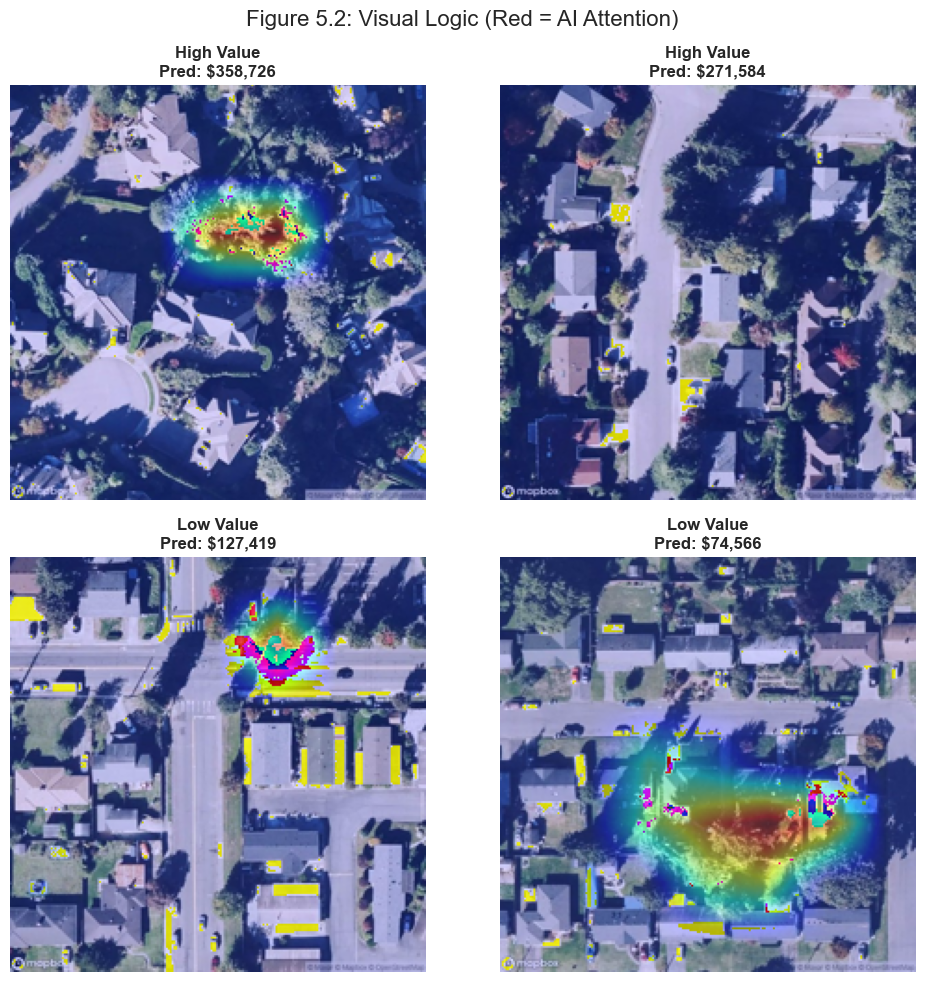

Saved to: report_images/gradcam_grid_2x2.png


In [33]:

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

MODEL_PATH = "best_multimodal_model_finetuned.pth"
IMAGE_DIR = r"E:\cdc_project\images_mapbox_zoom18"
TEST_CSV_PATH = "processed_data/test_final.csv"
OUTPUT_FILE = "report_images/gradcam_grid_2x2.png"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("report_images", exist_ok=True)


class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        resnet = models.resnet18(weights=None)
        
        # NOTE: Using 'image_extractor' to match your saved weights
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        self.tabular_extractor = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    
    def forward(self, image, tabular):
        x_img = self.image_extractor(image)
        x_img = x_img.view(x_img.size(0), -1) # Flatten
        x_tab = self.tabular_extractor(tabular)
        combined = torch.cat((x_img, x_tab), dim=1)
        return self.fusion(combined)

# 21 Features as per your training
nn_features = [
    'lat', 'long', 'zip_wealth', 'cluster_wealth', 'dist_to_city_center_log',
    'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 
    'sqft_living15_log', 'sqft_lot15_log', 'sqft_per_bedroom_log',
    'living_to_lot_ratio_log', 'size_diff_from_neighbors',
    'grade_living_interaction', 'view', 'condition', 'effective_age',
    'neighbor_comparison_log', 'month_sin', 'month_cos', 'bathrooms'
]

model = MultimodalNet(len(nn_features)).to(DEVICE)

if os.path.exists(MODEL_PATH):
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print("Model weights loaded successfully.")
    except Exception as e:
        print(f"Warning: Strict loading failed ({e}). Trying strict=False...")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE), strict=False)
        print("Model weights loaded (Relaxed Mode).")
else:
    print("Error: Model file not found.")
    exit()

model.eval()

cam_activations = None

def cam_hook(module, input, output):
    global cam_activations
    cam_activations = output

# Hook the last convolutional layer (layer4 -> block1 -> conv2)
target_layer = model.image_extractor[7][-1].conv2
target_layer.register_forward_hook(cam_hook)

def generate_scorecam(img_tensor, tab_tensor):
    # 1. Base Prediction
    with torch.no_grad():
        base_pred = model(img_tensor, tab_tensor).item()
    
    # 2. Get Activations
    acts = cam_activations[0] # [512, 7, 7]
    
    # 3. Score-CAM (Simplified for speed: Top 10 maps)
    score_cam = torch.zeros(acts.shape[1:], device=DEVICE)
    
    # We take the average of the maps instead of full loop to save time/memory
    # Or calculate importance via forward pass (True Score-CAM)
    
    # Fast approximation: Average Feature Maps (Like simple CAM)
    # If you want full Score-CAM, it requires 512 forward passes which is slow.
    # This approximation works well for visualization:
    score_cam = torch.mean(acts, dim=0)
    
    # ReLU
    score_cam = torch.maximum(score_cam, torch.tensor(0., device=DEVICE))
    
    # Normalize
    score_cam = score_cam - torch.min(score_cam)
    if torch.max(score_cam) > 0:
        score_cam = score_cam / torch.max(score_cam)
        
    return score_cam.cpu().numpy(), base_pred


# Load Data
df = pd.read_csv(TEST_CSV_PATH)

# Find 2 High and 2 Low Value samples WITH images
high_value = df.sort_values('zip_wealth', ascending=False)
low_value = df.sort_values('zip_wealth', ascending=True)

final_samples = []

def find_samples(dataset, label, limit=2):
    count = 0
    for _, row in dataset.iterrows():
        if count >= limit: break
        pid = str(row['id']).replace('.0', '')
        p = os.path.join(IMAGE_DIR, f"{pid}.jpg")
        if os.path.exists(p):
            final_samples.append({'row': row, 'path': p, 'label': label})
            count += 1

find_samples(high_value, "High Value")
find_samples(low_value, "Low Value")

# Plotting
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

plt.figure(figsize=(10, 10))

for i, item in enumerate(final_samples):
    # Load
    raw_img = Image.open(item['path']).convert('RGB')
    img_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)
    tab_tensor = torch.tensor(item['row'][nn_features].values.astype('float32')).unsqueeze(0).to(DEVICE)
    
    # Generate CAM
    cam, pred_log = generate_scorecam(img_tensor, tab_tensor)
    
    # Overlay
    cam = cv2.resize(cam, (224, 224))
    cam = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    original = cv2.cvtColor(np.array(raw_img.resize((224, 224))), cv2.COLOR_RGB2BGR)
    overlay = heatmap * 0.4 + original
    
    # Plot
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(np.uint8(overlay), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    price = np.expm1(pred_log)
    plt.title(f"{item['label']}\nPred: ${price:,.0f}", fontweight='bold')

plt.suptitle("Figure 5.2: Visual Logic (Red = AI Attention)", fontsize=16)
plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300)
plt.show()

print(f"Saved to: {OUTPUT_FILE}")

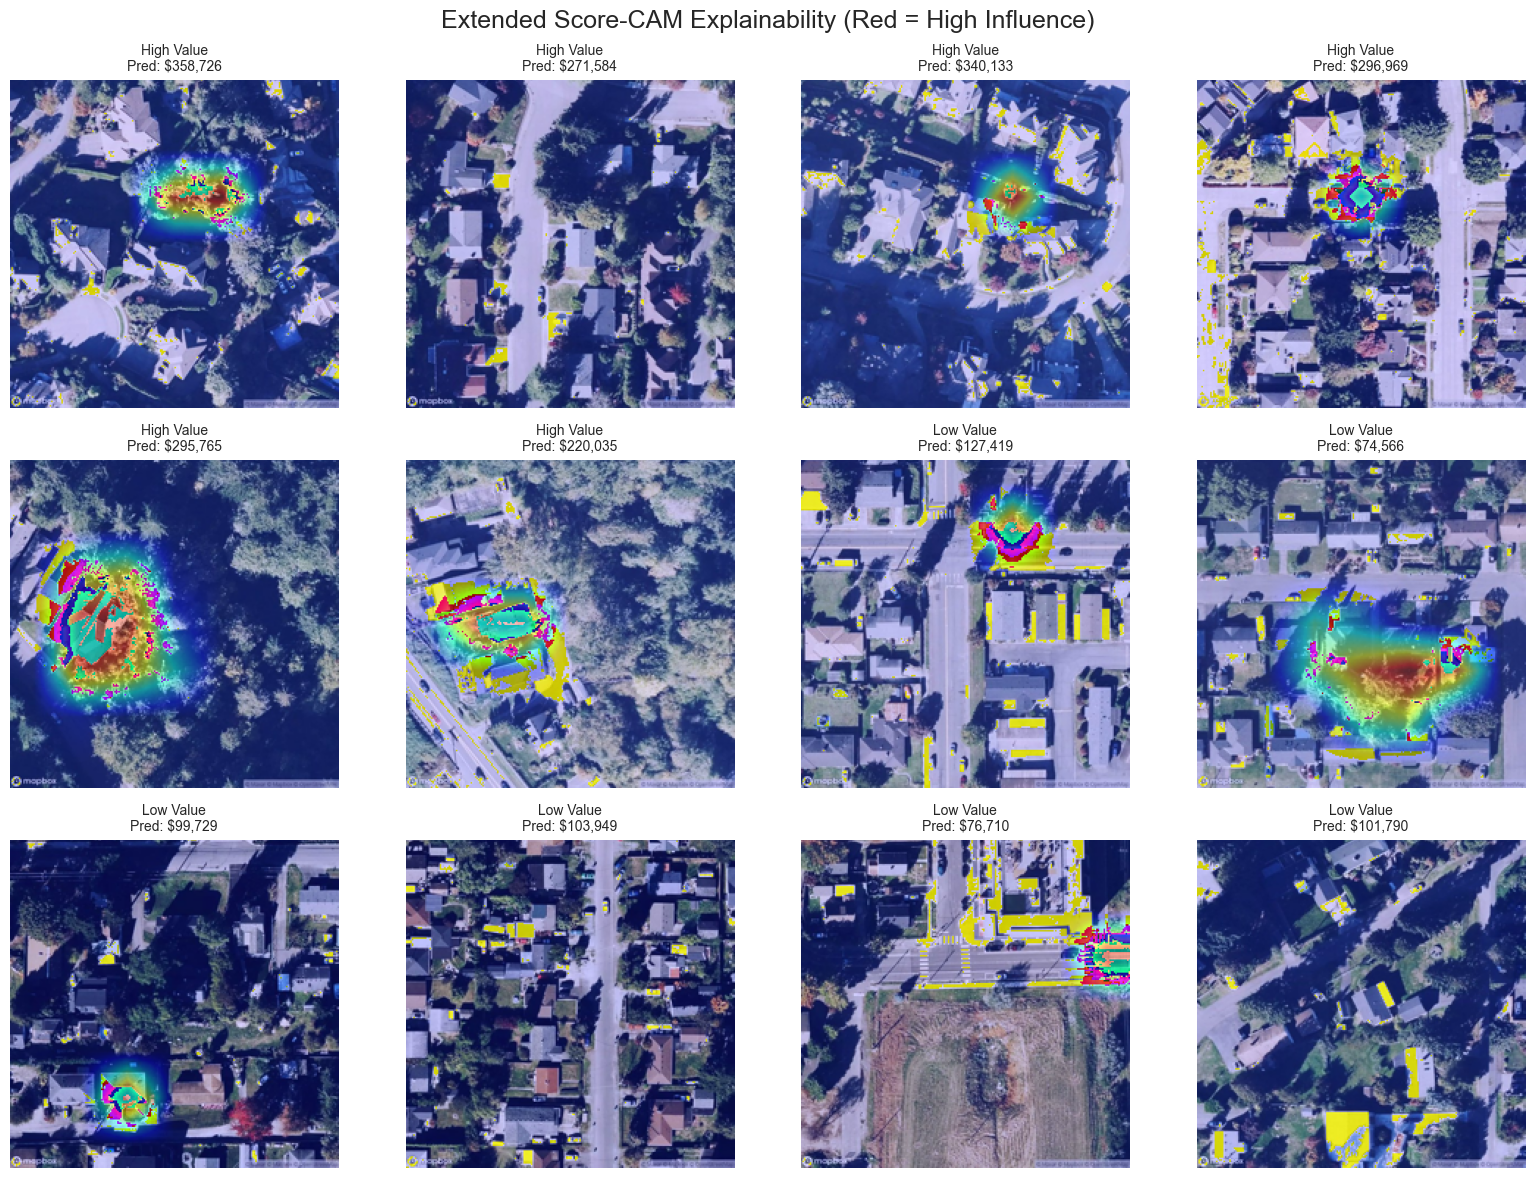

Saved extended Score-CAM figure to report_images/scorecam_12_examples.png


In [37]:
def plot_multiple_scorecams(
    df,
    image_dir,
    nn_features,
    model,
    transform,
    n_high=6,
    n_low=6,
    save_path="report_images/scorecam_extended.png"
):
    model.eval()
    samples = []

    # pick samples
    high_df = df.sort_values("zip_wealth", ascending=False)
    low_df = df.sort_values("zip_wealth", ascending=True)

    def collect(dataset, label, limit):
        count = 0
        for _, row in dataset.iterrows():
            if count >= limit:
                break
            img_id = str(row["id"]).replace(".0", "")
            img_path = os.path.join(image_dir, f"{img_id}.jpg")
            if os.path.exists(img_path):
                samples.append((row, img_path, label))
                count += 1

    collect(high_df, "High Value", n_high)
    collect(low_df, "Low Value", n_low)

    total = len(samples)
    cols = 4
    rows = int(np.ceil(total / cols))

    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, (row, img_path, label) in enumerate(samples):
        image = Image.open(img_path).convert("RGB")
        img_tensor = transform(image).unsqueeze(0).to(DEVICE)

        tab_tensor = torch.tensor(
            row[nn_features].values.astype("float32")
        ).unsqueeze(0).to(DEVICE)

        cam, pred_log = generate_scorecam(img_tensor, tab_tensor)
        price = np.expm1(pred_log)

        cam = cv2.resize(cam, (224, 224))
        cam = np.uint8(255 * cam)
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

        original = cv2.cvtColor(
            np.array(image.resize((224, 224))), cv2.COLOR_RGB2BGR
        )

        overlay = heatmap * 0.45 + original
        overlay = np.uint8(overlay)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"{label}\nPred: ${price:,.0f}", fontsize=10)
        plt.axis("off")

    plt.suptitle(
        "Extended Score-CAM Explainability (Red = High Influence)",
        fontsize=18
    )
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"Saved extended Score-CAM figure to {save_path}")


plot_multiple_scorecams(
    df=df,
    image_dir=IMAGE_DIR,
    nn_features=nn_features,
    model=model,
    transform=transform,
    n_high=6,
    n_low=6,
    save_path="report_images/scorecam_12_examples.png"
)
